In [163]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from tqdm import tqdm
import random

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the dataset and exploration

In [3]:
# load data
df = pd.DataFrame()

for path in glob.glob("data/*.RData"):
    _df = pyreadr.read_r(path)
    k = list(_df.keys())[0]
    _df =  _df[k]
    df = pd.concat([df, _df]).astype(np.float32)

df = df.reset_index()
df.head(5)

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1.0,0.25171,3672.399902,4466.299805,9.5122,27.056999,42.473000,...,54.493999,24.527000,59.709999,22.357000,40.148998,40.074001,47.955002,47.299999,42.099998,15.345000
1,1,0.0,1.0,2.0,0.25234,3642.199951,4568.700195,9.4145,26.999001,42.585999,...,53.269001,24.465000,60.466000,22.413000,39.956001,36.651001,45.037998,47.501999,40.553001,16.063000
2,2,0.0,1.0,3.0,0.24840,3643.100098,4507.500000,9.2901,26.927000,42.278000,...,54.000000,24.860001,60.641998,22.198999,40.074001,41.868000,44.553001,47.479000,41.341000,20.452000
3,3,0.0,1.0,4.0,0.25153,3628.300049,4519.299805,9.3347,26.999001,42.330002,...,53.860001,24.552999,61.908001,21.981001,40.140999,40.066002,48.048000,47.439999,40.779999,17.122999
4,4,0.0,1.0,5.0,0.21763,3655.800049,4571.000000,9.3087,26.900999,42.402000,...,53.306999,21.775000,61.890999,22.412001,37.695999,38.294998,44.678001,47.529999,41.089001,18.681000


In [4]:
df.describe()

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,...,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07
mean,3.830818e+06,1.000003e+01,2.505003e+02,4.017329e+02,2.578313e-01,3.664629e+03,4.508767e+03,9.381279e+00,2.690145e+01,4.237013e+01,...,5.456402e+01,2.948042e+01,6.346111e+01,2.312506e+01,3.950932e+01,3.805743e+01,4.643279e+01,4.987652e+01,4.196305e+01,1.915971e+01
std,2.698727e+06,6.055301e+00,1.443373e+02,2.637147e+02,1.409454e-01,4.290828e+01,1.070059e+02,3.671576e-01,2.282361e-01,3.164791e-01,...,6.753467e+00,1.939544e+01,8.219346e+00,1.192272e+01,1.279515e+01,2.942525e+00,2.347796e+00,1.714415e+01,1.100319e+01,7.642519e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-4.985500e-03,3.308400e+03,3.540700e+03,6.639900e+00,2.534800e+01,3.965600e+01,...,7.348400e+00,-3.586600e-01,-5.222600e-03,-1.068800e-01,0.000000e+00,2.228800e+01,3.336900e+01,-6.834200e-01,-5.156500e-01,-6.774200e-03
25%,1.551250e+06,5.000000e+00,1.257500e+02,1.830000e+02,2.196600e-01,3.637400e+03,4.472300e+03,9.271300e+00,2.676200e+01,4.218700e+01,...,5.353800e+01,2.225300e+01,6.035000e+01,2.152700e+01,3.839200e+01,3.601800e+01,4.486600e+01,4.547400e+01,4.061300e+01,1.712400e+01
50%,3.467500e+06,1.000000e+01,2.505000e+02,3.655000e+02,2.506600e-01,3.663800e+03,4.509100e+03,9.355400e+00,2.690000e+01,4.234900e+01,...,5.397800e+01,2.507500e+01,6.148500e+01,2.214100e+01,3.994800e+01,3.812400e+01,4.633500e+01,4.804000e+01,4.118900e+01,1.826400e+01
75%,5.767499e+06,1.500000e+01,3.752500e+02,5.952500e+02,2.804700e-01,3.690400e+03,4.546600e+03,9.448800e+00,2.704100e+01,4.252300e+01,...,5.442700e+01,2.828900e+01,6.275900e+01,2.269300e+01,4.139000e+01,3.997900e+01,4.802300e+01,5.141500e+01,4.184800e+01,1.948300e+01
max,9.599999e+06,2.000000e+01,5.000000e+02,9.600000e+02,1.017500e+00,3.906700e+03,5.175800e+03,1.224000e+01,2.856500e+01,4.465300e+01,...,1.000000e+02,1.002100e+02,1.000200e+02,1.001100e+02,9.752800e+01,5.423000e+01,6.021600e+01,1.005800e+02,1.006100e+02,1.000100e+02


In [5]:
df["faultNumber"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.], dtype=float32)

In [6]:
df["faultNumber"] = df["faultNumber"].astype(int)
df = df.drop(["simulationRun", "sample", "index"], axis=1)

In [7]:
# remove 3, 9 and 15
mask = ~df["faultNumber"].isin([3, 9, 15])

In [8]:
df = df[mask]
df["faultNumber"].value_counts(sort=False)

faultNumber
0     730000
1     730000
2     730000
4     730000
5     730000
6     730000
7     730000
8     730000
10    730000
11    730000
12    730000
13    730000
14    730000
16    730000
17    730000
18    730000
19    730000
20    730000
Name: count, dtype: int64

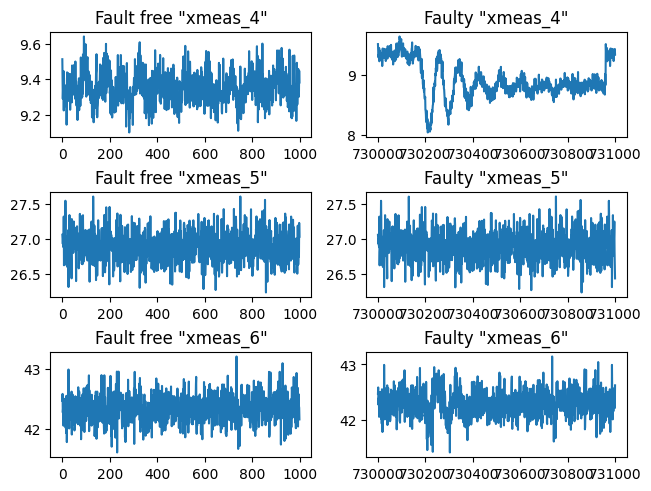

In [9]:
keys = df.columns[4:7]
fault_free = df[df["faultNumber"] == 0].iloc[:1_000]
fault = df[df["faultNumber"] > 0].iloc[:1_000]

fig, ax = plt.subplots(3, 2, constrained_layout=True)
#fig.tight_layout()

for i, key in enumerate(keys):
    ax[i][0].set_title(f'Fault free "{key}"')
    ax[i][0].plot(fault_free[key])
    ax[i][1].set_title(f'Faulty "{key}"')
    ax[i][1].plot(fault[key])
plt.show()

# Statistical analysis (Threshold)

<img src="images/normal-distribution.png" width="500" height="340">

Reference: [Normal distribution ](https://hammychang.medium.com/normal-distributions-2e395d596c42)

In [10]:
mean = fault_free.mean(axis=0)
std = fault_free.std(axis=0)

upper_limit = mean+3*std
lower_limit = mean-3*std

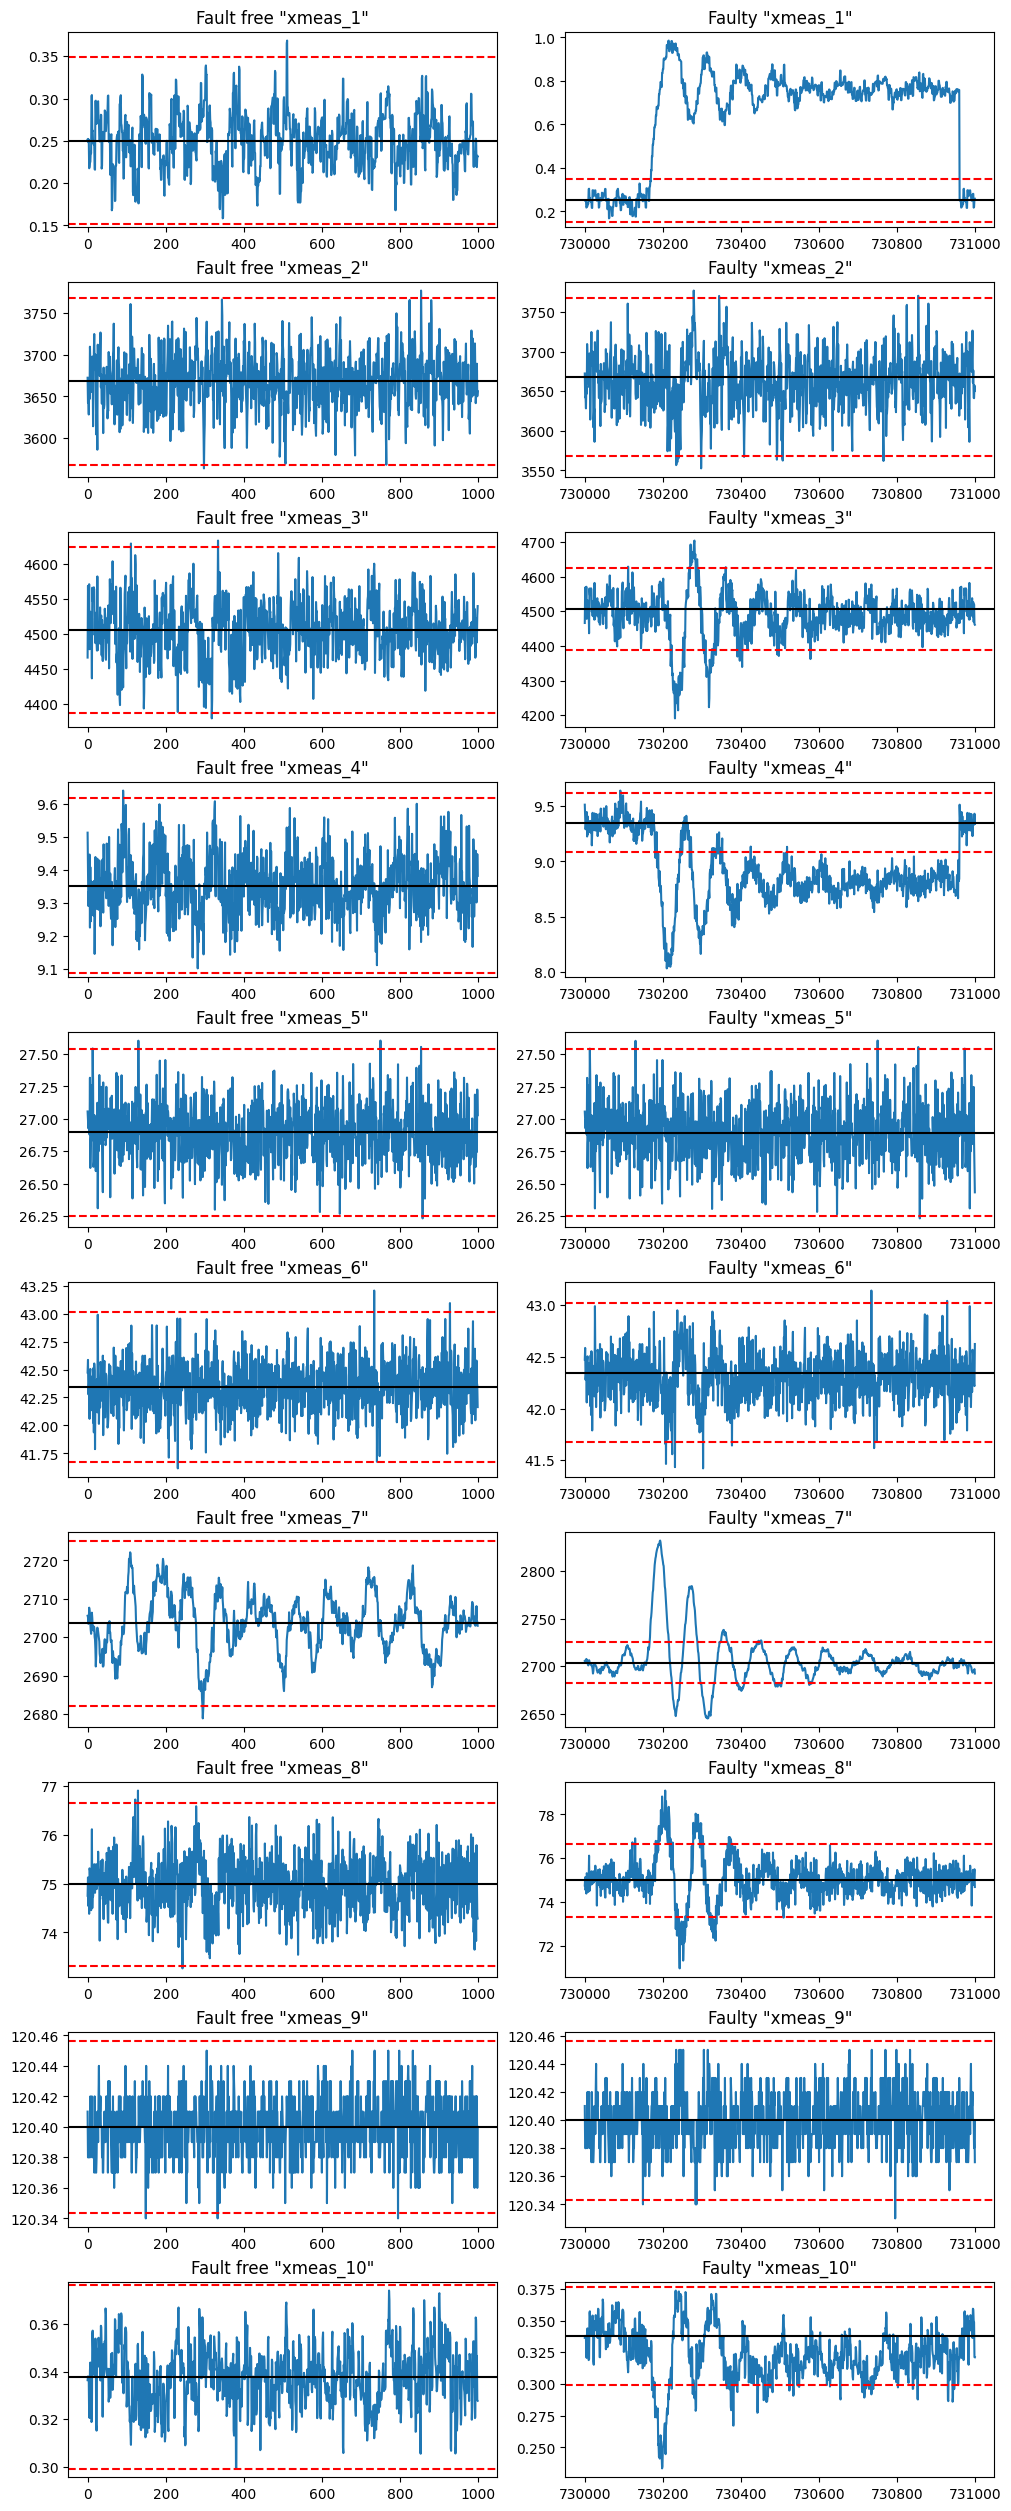

In [11]:
keys = fault.keys()[1:11]

fig, ax = plt.subplots(len(keys), 2, figsize=(10, 25), constrained_layout=True)
simulation_run = 1

for i, key in enumerate(keys):
    ax[i][0].set_title(f'Fault free "{key}"')
    ax[i][0].plot(fault_free[key])
    ax[i][0].axhline(mean[key],c='k')
    ax[i][0].axhline(upper_limit[key],ls='--',c='r')
    ax[i][0].axhline(lower_limit[key],ls='--',c='r')
    
    ax[i][1].set_title(f'Faulty "{key}"')
    ax[i][1].plot(fault[key])
    ax[i][1].axhline(mean[key],c='k')
    ax[i][1].axhline(upper_limit[key],ls='--',c='r')
    ax[i][1].axhline(lower_limit[key],ls='--',c='r')
plt.show()

# Statistical detection

In [12]:
# mean, stddev, upper limit, lower limit
mean = df[df["faultNumber"] == 0].mean(axis=0)
std = df[df["faultNumber"] == 0].std(axis=0)

upper_limit = mean+4*std
lower_limit = mean-4*std

def is_anomaly(column, key):
    result = ((column < lower_limit[key]).any()) or ((column > upper_limit[key]).any())
    return 1 if result else 0
is_anomaly = np.vectorize(is_anomaly)

In [13]:
features = list(df.columns[1:])

result_rows = {}

with tqdm(total=len(df.columns[1:])) as pbar:
    for col in df.columns[1:]:
        result = is_anomaly(df[col], col)
        result_rows[col] = result
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [38:45<00:00, 44.72s/it]


In [29]:
df_results =  pd.DataFrame(result_rows)
df_results["y_pred"] = pd.DataFrame(result_rows).max(axis=1)

In [64]:
to_binary = np.vectorize(lambda val: 1 if val > 0 else 0)
df_results["y_true"] = to_binary(df["faultNumber"].values)

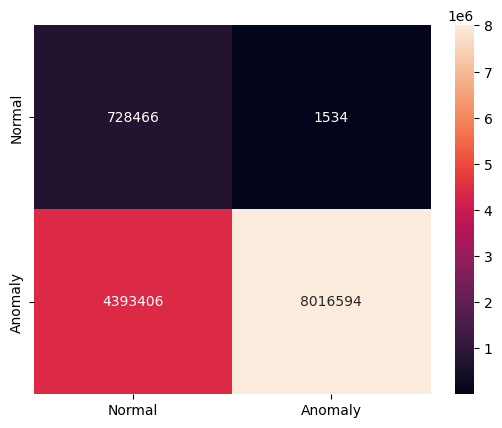

Accuracy: 0.6655296803652968


In [66]:
df_results.to_csv("statistical_results.csv")
cm = confusion_matrix(df_results["y_true"].values, df_results["y_pred"].values)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

print(f"Accuracy: {accuracy_score(df_results['y_pred'].values, df_results['y_true'].values)}")

In [100]:
false_postive_mask = (df_results["y_true"] == 0) & (df_results["y_pred"] == 1)
example = random.choice(df_results[false_postive_mask].index.to_list())

In [127]:
df_results[(df_results.loc[example, df_results.columns != "y_pred"] == 1).name]

KeyError: 355062

In [87]:
fig, ax = plt.subplots(3, 2, constrained_layout=True)

for feature in df.columns[1:5]:
    print(feature)

xmeas_1
xmeas_2
xmeas_3
xmeas_4


# Unsupervised - Variational Autoencoder

## Data scaling

In [128]:
# features
X = df.loc[:, df.columns != "faultNumber"].values
# labels
y = df["faultNumber"].values

X.shape, y.shape

((13140000, 52), (13140000,))

In [129]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X.shape

(13140000, 52)

In [130]:
scaled_df = pd.DataFrame(scaled_X, columns=df.columns[df.columns != "faultNumber"])
scaled_df.head(3)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.048403,0.172460,-0.370898,0.317191,0.674035,0.295624,-0.255478,-0.073291,0.133955,-0.109065,...,-0.023099,-0.276875,-0.466629,-0.071480,0.052981,0.688630,0.655753,-0.156733,-0.000211,-0.485108
1,-0.044249,-0.510476,0.523798,0.069668,0.422896,0.638368,-0.260357,0.202214,-0.273702,-0.090801,...,-0.191197,-0.279855,-0.380834,-0.067129,0.039000,-0.476263,-0.587067,-0.145792,-0.130463,-0.397765
2,-0.070227,-0.490120,-0.010922,-0.245499,0.111128,-0.295842,-0.281081,-0.227163,-0.273702,-0.102173,...,-0.090887,-0.260867,-0.360861,-0.083757,0.047548,1.299152,-0.793705,-0.147038,-0.064116,0.136149


In [131]:
scaled_df.describe()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,...,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07
mean,7.063268e-09,1.876092e-08,4.310972e-09,1.722376e-08,-4.559638e-09,2.977583e-09,2.049558e-08,1.242477e-08,-4.031306e-09,-1.207748e-08,...,4.657363e-09,-3.253815e-09,2.152401e-08,1.117889e-08,6.446063e-09,-9.696414e-09,-1.033467e-08,2.916182e-10,-5.604379e-09,-7.609581e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.740880e+00,-8.058971e+00,-8.458078e+00,-6.959772e+00,-6.726068e+00,-8.248803e+00,-3.812834e+00,-1.005158e+01,-1.073462e+01,-3.762002e+00,...,-6.492572e+00,-1.473142e+00,-7.243393e+00,-1.816945e+00,-2.855521e+00,-5.364186e+00,-5.558764e+00,-2.755571e+00,-3.588297e+00,-2.352624e+00
25%,-2.778506e-01,-6.325884e-01,-3.394432e-01,-3.047841e-01,-5.990027e-01,-5.718589e-01,-3.505694e-01,-3.180220e-01,-2.737016e-01,-2.699889e-01,...,-1.584010e-01,-3.899846e-01,-3.967221e-01,-1.437417e-01,-8.705027e-02,-6.947453e-01,-6.641835e-01,-2.670048e-01,-1.289476e-01,-2.688180e-01
50%,-5.512808e-02,-2.201518e-02,3.932585e-03,-7.474185e-02,-5.785626e-03,-7.441556e-02,-2.554785e-01,6.812580e-02,-1.930217e-03,-1.143486e-01,...,-9.376872e-02,-2.452922e-01,-2.602001e-01,-8.973956e-02,3.639201e-02,2.637881e-02,-4.895223e-02,-1.139454e-01,-7.539855e-02,-1.264896e-01
75%,1.561220e-01,5.953433e-01,3.560413e-01,1.917815e-01,6.047587e-01,4.715433e-01,-1.396633e-01,4.220346e-01,2.697375e-01,2.877140e-02,...,-2.748964e-02,-7.411289e-02,-1.013213e-01,-4.265271e-02,1.483162e-01,6.474512e-01,6.757765e-01,9.879981e-02,-1.082001e-02,2.763873e-02
max,5.000699e+00,5.470881e+00,5.828167e+00,7.228061e+00,7.203800e+00,6.907922e+00,3.339667e+00,9.041111e+00,8.285336e+00,5.453893e+00,...,6.221384e+00,3.361250e+00,4.107939e+00,5.970003e+00,4.209672e+00,5.506107e+00,5.879678e+00,2.728975e+00,4.926123e+00,9.814239e+00


In [132]:
def create_samples(X, y, lookback=5):
    x_out = []
    y_out = []
    with tqdm(total=len(X)-lookback-1) as pbar:
        for i in range(len(X)-lookback-1):
            _x = X[i:i+lookback, :]
            _y = y[i+lookback+1]
            x_out.append(_x)
            y_out.append(_y)
            pbar.update(1)

    print("Preparing numpy return. This could take some seconds.")
    return np.array(x_out), np.array(y_out)

In [136]:
_x, _y = create_samples(scaled_df.values, y)
_x.shape, _y.shape

100%|█████████████████████████████████████████████████████████████████| 13139994/13139994 [00:05<00:00, 2445726.65it/s]


Preparing numpy return. This could take some seconds.


((13139994, 5, 52), (13139994,))

In [137]:
X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [138]:
# Data split
print("Train:")
print(f"All samples: {X_train.shape[0]}")
print(f"Without anomalies: {X_train[y_train == 0].shape[0]}")
# Test samples
print("Test:")
print(f"All samples: {X_test.shape[0]}")
print(f"Without anomalies: {X_test[y_test == 0].shape[0]}")
# Train samples
print("Validation:")
print(f"All samples: {X_val.shape[0]}")

Train:
All samples: 9197995
Without anomalies: 511426
Test:
All samples: 1971000
Without anomalies: 109288
Validation:
All samples: 1970999


## LSTM VAE

### Encoder

In [147]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        return hidden_state[-1]

### Decoder

In [140]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        # reconstruction
        self.linear_recon = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        return self.linear_recon(output)

### VAE

In [150]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, device, dropout=0.0):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.device = device

        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)

        self.decoder = Decoder(
            input_size=latent_size, # compressed vector size
            hidden_size=hidden_size,
            output_size=input_size, # reconstruction of features at timestep
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)

        self.z_mean = nn.Linear((self.hidden_size), self.latent_size).to(self.device)
        self.z_log_var = nn.Linear((self.hidden_size), self.latent_size).to(self.device)

    def reparametrize(self, z_mu, z_log_var):
        # mu - mean vector
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(self.device)
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, X):
        batch_size, seq_len, features_dim = X.shape

        # encode
        # tensor of shape: 1*num_layers, batch_size, hidden_size
        enc_hidden = self.encoder(X)
        enc_hidden = enc_hidden.transpose(0, 1).contiguous().view(batch_size, -1) # (batch_size, hidden_size*num_layers)

        # extract latent variable z (hidden to latent)
        _z_mean = self.z_mean(enc_hidden)
        _z_log_var = self.z_log_var(enc_hidden)
        z = self.reparametrize(_z_mean, _z_log_var) # Shape: batch_size, latent_size
        z = z.unsqueeze(1).repeat(1, seq_len, 1)

        decoded = self.decoder(z)

        return decoded, _z_mean, _z_log_var


In [142]:
def vae_loss(pred, label, z_mean, z_log_var):
    reconstruction_loss = F.mse_loss(pred, label)
    kl_div = torch.mean(
            -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), dim=1), dim=0
        )
    loss = reconstruction_loss + kl_div #*kld_weight
    return loss, reconstruction_loss

### Dataset

In [143]:
class TEP(Dataset):
    def __init__(self, x, y):
        super(TEP, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        _x = self.x[idx]
        _y = self.y[idx]
        return _x, _y

In [144]:
train_data = TEP(X_train[y_train == 0], y_train[y_train == 0])
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [145]:
test_data = TEP(X_test[y_test == 0], y_test[y_test == 0])
testloader = DataLoader(test_data, batch_size=256)

In [152]:
num_epochs = 20

# model
learning_rate = 0.0002
model = VAE(input_size=52, hidden_size=128, latent_size=32, num_layers=12, device=device, dropout=0.2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

result_rows = []

model.train()
train_losses = []
test_losses = []
for i in range(num_epochs):
    _train_losses = []
    _train_reconstruction_losses = []
    _test_losses = []
    _test_reconstruction_losses = []
    with tqdm(total=len(trainloader)) as pbar:
        for x, y in trainloader:
            x = x.to(device)
            pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.detach().item()
            _train_losses.append(loss)
            reconstruction_loss = reconstruction_loss.detach().item()
            _train_reconstruction_losses.append(reconstruction_loss)
            
            pbar.update(1)
        
        for x, y in testloader:
            x = x.to(device)
            with torch.no_grad():
                pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)
            loss = loss.detach().item()
            _test_losses.append(loss)
            reconstruction_loss = reconstruction_loss.detach().item()
            _test_reconstruction_losses.append(reconstruction_loss)

        # epoch losses
        e_train = np.mean(_train_losses)
        e_test = np.mean(_test_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
            
                
        print(f"Epoch {i+1} - train loss: {e_train} - test loss: {e_test}")
        torch.save(model.state_dict(), f"./model/vae/model.pt")

        result_rows.append(
            {
                "train_loss": e_train,
                "train_reconstruction_loss": np.mean(_train_reconstruction_losses),
                "test_loss": e_test,
                "test_reconstruction_loss": np.mean(_test_reconstruction_losses)
            }
        )

100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.28it/s]


Epoch 1 - train loss: 0.29116163142510243 - test loss: 0.27257375666910927


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:54<00:00, 36.45it/s]


Epoch 2 - train loss: 0.26804817273273124 - test loss: 0.26416944208133974


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.05it/s]


Epoch 3 - train loss: 0.26166697963699326 - test loss: 0.2592311803015948


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.11it/s]


Epoch 4 - train loss: 0.25766094752379487 - test loss: 0.2560047056063556


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:54<00:00, 36.34it/s]


Epoch 5 - train loss: 0.2550164860886735 - test loss: 0.2538549578999468


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.02it/s]


Epoch 6 - train loss: 0.2532465354920746 - test loss: 0.252412705496826


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.05it/s]


Epoch 7 - train loss: 0.2520582439663174 - test loss: 0.2514434292458818


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 35.99it/s]


Epoch 8 - train loss: 0.25126106453102987 - test loss: 0.25079243035171295


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 35.98it/s]


Epoch 9 - train loss: 0.25072750537931265 - test loss: 0.25035565986845476


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:54<00:00, 36.33it/s]


Epoch 10 - train loss: 0.250367542876078 - test loss: 0.2500617339055488


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.13it/s]


Epoch 11 - train loss: 0.2501264129568626 - test loss: 0.24986567932772133


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:54<00:00, 36.36it/s]


Epoch 12 - train loss: 0.24996446047697937 - test loss: 0.24973338905207168


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:54<00:00, 36.43it/s]


Epoch 13 - train loss: 0.24985738269410454 - test loss: 0.24964477889571313


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 35.78it/s]


Epoch 14 - train loss: 0.24978587524340795 - test loss: 0.24958567000245044


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:58<00:00, 33.96it/s]


Epoch 15 - train loss: 0.24973608233459718 - test loss: 0.24954464899013976


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:56<00:00, 35.10it/s]


Epoch 16 - train loss: 0.24970321437051227 - test loss: 0.24951782522491883


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 35.99it/s]


Epoch 17 - train loss: 0.24968102569873626 - test loss: 0.2494990272530348


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.16it/s]


Epoch 18 - train loss: 0.2496651530459717 - test loss: 0.2494864828134309


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:55<00:00, 36.17it/s]


Epoch 19 - train loss: 0.24965471002432676 - test loss: 0.2494774847106018


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:56<00:00, 35.63it/s]

Epoch 20 - train loss: 0.24964728069168193 - test loss: 0.24947113810713453


In [153]:
results = pd.DataFrame(result_rows)
results.to_csv("vae_results.csv")
results

,train_loss,train_reconstruction_loss,test_loss,test_reconstruction_loss
0,0.291162,0.273683,0.272574,0.269149
1,0.268048,0.265909,0.264169,0.262791
2,0.261667,0.260642,0.259231,0.258469
3,0.257661,0.257059,0.256005,0.255527
4,0.255016,0.254623,0.253855,0.253529
5,0.253247,0.252970,0.252413,0.252174
6,0.252058,0.251851,0.251443,0.251260
7,0.251261,0.251098,0.250792,0.250644
8,0.250728,0.250593,0.250356,0.250231
9,0.250368,0.250253,0.250062,0.249954


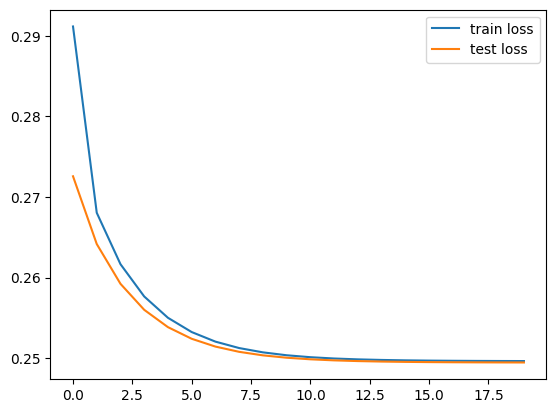

In [154]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

### Reconstruction plot

In [155]:
sample = X_test[y_test == 0][:100]
with torch.no_grad():
    pred, _, _ = model(torch.from_numpy(sample).to(torch.float32).to(device))
pred = pred.cpu()
pred.shape

torch.Size([100, 5, 52])

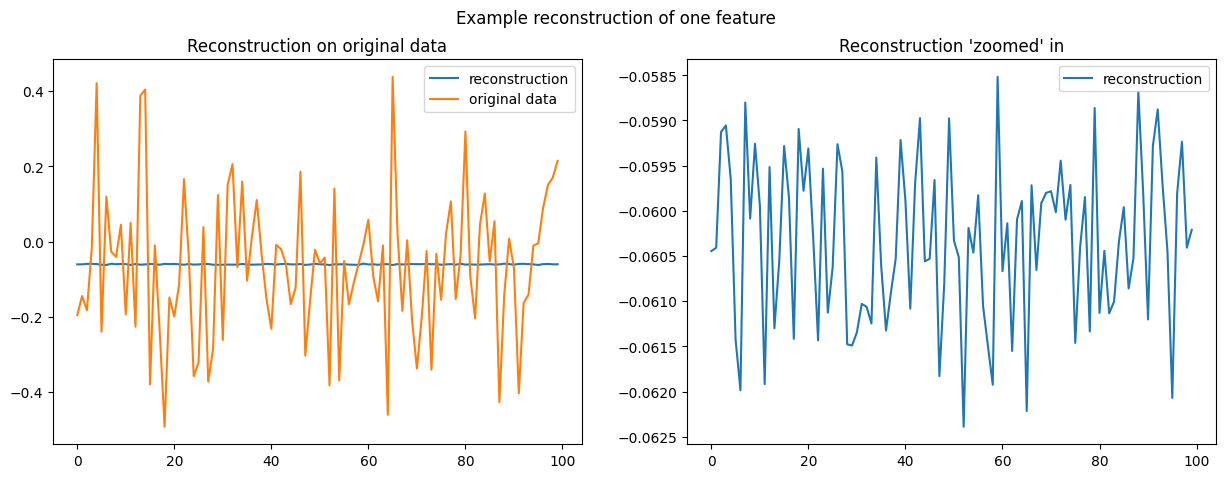

In [156]:
fix, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(pred[:, 0, 0], label="reconstruction")
ax[0].plot(sample[:, 0, 0], label="original data")
ax[0].title.set_text("Reconstruction on original data")
ax[0].legend()
ax[1].plot(pred[:, 0, 0], label="reconstruction")
ax[1].title.set_text("Reconstruction 'zoomed' in")
ax[1].legend()
plt.suptitle("Example reconstruction of one feature")
plt.show()

### Evaluation on validation data

In [160]:
y_hat = []
y_true = []

reconstruction_loss = results["train_reconstruction_loss"].max()

with tqdm(total=X_val.shape[0]) as pbar:
    for x, y in zip(X_val, y_val):
        with torch.no_grad():
            x = torch.from_numpy(x).to(device)
            x = x[None, :, :]
            pred, _, _ = model(x)
        error = F.mse_loss(pred, x).cpu().item()
        
        y_true.append(1 if y > 0 else 0)
        y_hat.append(1 if error > reconstruction_loss else 0)
        
        pbar.update(1)

accuracy_score(y_true, y_hat)

 30%|█████████████████████▊                                                  | 595619/1970999 [18:31<42:46, 535.81it/s]


KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame({"y_pred": y_hat, "y_true": y_true})
results.to_csv("evaluation_results.csv")

In [ ]:
cm = confusion_matrix(y_true, y_hat)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

# Supervised - XGBoost & LSTM

## XGBoost binary classification

In [161]:
x_train_sequence = X_train[:, 0, :].astype(np.float32)
y_train_binary = to_binary(y_train)
x_val_sequence = X_val[:, 0, :].astype(np.float32)
y_val_binary = to_binary(y_val)

In [164]:
xgb_model = XGBClassifier(device='cuda')
optimization_dict = {'max_depth': [2,4,6], 'n_estimators': [50,100,200], "eta": [0.3, 0.03, 0.003]}

model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1)
model.fit(x_train_sequence, y_train_binary)

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [ ]:
best_model = model.best_estimator_
best_model.save_model('./model/xgboost/XGBClassifier_binary.json')

In [166]:
# loading trained model
best_model = XGBClassifier(device='cuda')
best_model.load_model('./model/xgboost/XGBClassifier_binary.json')

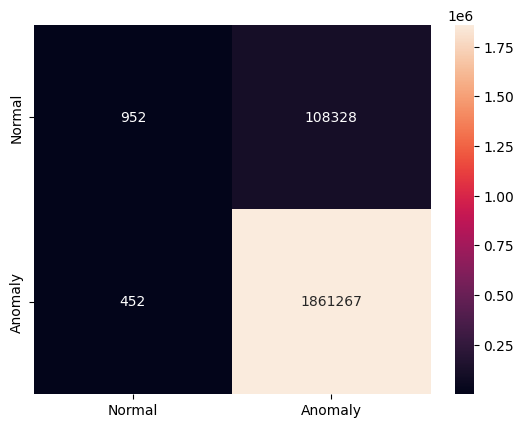

0.9448097132469372

In [170]:
predictions = best_model.predict(x_val_sequence)
cm = confusion_matrix(y_val_binary, predictions)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

accuracy_score(y_val_binary, predictions)

## XGBoost muti-label classification

In [171]:
# Because 3, 9 and 15 were removed
label_mapping = {k: i for i, k in enumerate(set(y_train))}
reverse_label_mapping = {i: k for i, k in enumerate(set(y_train))}

rearrange_labels = np.vectorize(lambda x: label_mapping[x])
reverse_map_labels = np.vectorize(lambda x: reverse_label_mapping[x])

In [172]:
y_train_multilabel = rearrange_labels(y_train)
y_val_multilabel = rearrange_labels(y_val)

**CAUTION:** The next cell can take around 7h to run.

Here are the results from the saved model:

```
0.8248341078680734
{'eta': 0.3, 'max_depth': 6, 'n_estimators': 200}
```

In [ ]:
xgb_model = XGBClassifier(device='cuda', objective="multi:softprob")
optimization_dict = {'max_depth': [2,4,6], 'n_estimators': [50,100,200], "eta": [0.3, 0.03, 0.003]}

model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1)
model.fit(x_train_sequence, y_train_multilabel)

print(model.best_score_)
print(model.best_params_)

In [ ]:
best_model = model.best_estimator_
best_model.save_model("./model/xgboost/XGBClassifier_multilabel.json)

In [173]:
# loading trained model
best_model = XGBClassifier(device='cuda', objective="multi:softprob")
best_model.load_model("./model/xgboost/XGBClassifier_multilabel.json")

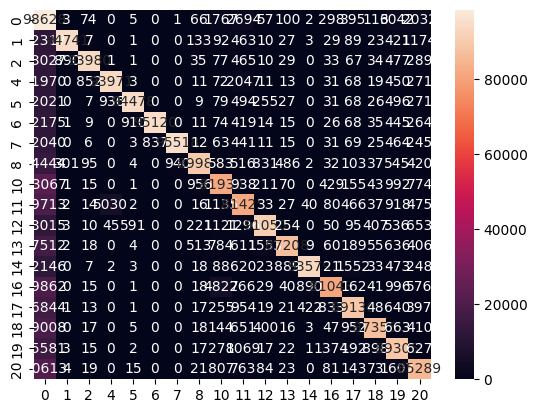

<Figure size 1500x1500 with 0 Axes>

0.8238157401398986

In [180]:
predictions = best_model.predict(x_val_sequence)
cm = confusion_matrix(y_val_multilabel, predictions)
cols = list(set(reverse_map_labels(y_val_multilabel)))
df_cm = pd.DataFrame(cm, index=cols, columns=cols)
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.figure(figsize=(15,15))
plt.show()

accuracy_score(y_val_multilabel, predictions)

## LSTM binary classification

In [181]:
class BinaryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(BinaryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.linear1 = nn.Linear(hidden_size, 1)

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        output = self.linear1(output[:, -1, :])
        output = torch.sigmoid(output)
        return output

In [182]:
train_data = TEP(X_train, y_train_binary)
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [183]:
y_test_binary = to_binary(y_test)

test_data = TEP(X_test, y_test_binary)
testloader = DataLoader(test_data, batch_size=256)

In [184]:
class EarlyStopping:
    def __init__(self, tolerance=3, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_accuracy = None

    def __call__(self, test_accuracy):
        if self.best_accuracy is None:
            self.best_accuracy = test_accuracy
        else:
            if (test_accuracy - self.min_delta) > self.best_accuracy:
                self.best_accuracy = test_accuracy
            else:
                self.counter += 1
                if self.counter > self.tolerance:
                    self.early_stop = True
                    print("Early stopping!")

In [185]:
num_epochs = 20

# model
learning_rate = 0.0002
model = BinaryLSTM(input_size=52, hidden_size=128, num_layers=12, dropout=0.2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.BCELoss()

early_stopper = EarlyStopping()

best_acc = 0
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(num_epochs):
    train_epoch_losses = []
    test_epoch_losses = []
    with tqdm(total=len(trainloader)) as pbar:
        model.train()
        for x, y in trainloader:
            x = x.to(torch.float32).to(device)
            y = y[:, None]
            y = y.to(torch.float32).to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.detach().item()
            train_epoch_losses.append(loss)
            
            pbar.update(1)
        train_acc = (pred.round() == y).float().mean()
        
        model.eval()
        for x, y in testloader:
            x = x.to(torch.float32).to(device)
            y = y[:, None]
            y = y.to(torch.float32).to(device)
            with torch.no_grad():
                pred = model(x)
            loss = loss_fn(pred, y)
            loss = loss.detach().item()
            test_epoch_losses.append(loss)
        test_acc = (pred.round() == y).float().mean()

        # evaluations
        e_train = np.mean(train_epoch_losses)
        e_test = np.mean(test_epoch_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
                
        print(f"Epoch {i+1} - train loss: {e_train} train acc: {train_acc} \
            \t test loss: {e_test} test acc: {test_acc}")

        if test_acc > best_acc:
            torch.save(model.state_dict(), "./model/binary_lstm/model.pt")

        early_stopper(test_acc)
        if early_stopper.early_stop:
            break

  3%|██▏                                                                           | 997/35930 [00:12<07:21, 79.17it/s]


KeyboardInterrupt: 

In [ ]:
# TODO: validation

## LSTM multi-label classification

In [186]:
class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(ClassificationLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.intermediate_size = hidden_size//2
        self.linear1 = nn.Linear(hidden_size, self.intermediate_size)
        self.linear2 = nn.Linear(self.intermediate_size, output_size)

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        output = self.linear1(output[:, -1, :])
        output = self.linear2(output)
        return output

In [187]:
train_data = TEP(X_train, y_train_multilabel)
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [188]:
y_test_multilabel = rearrange_labels(y_test)

test_data = TEP(X_test, y_test_multilabel)
testloader = DataLoader(test_data, batch_size=256)

In [190]:
num_epochs = 20

# model
learning_rate = 0.002
model = ClassificationLSTM(input_size=52, hidden_size=256, num_layers=12, output_size=len(set(y_train_multilabel)) ,dropout=0.2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
steps = num_epochs*len(trainloader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps//3)
loss_fn = nn.CrossEntropyLoss()

early_stopper = EarlyStopping()

best_acc = 0
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(num_epochs):
    train_epoch_losses = []
    test_epoch_losses = []
    train_correct = 0
    train_samples = 0
    test_correct = 0
    test_samples = 0
    with tqdm(total=len(trainloader)) as pbar:
        model.train()
        for x, y in trainloader:
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.detach().item()
            train_epoch_losses.append(loss)
            
            pbar.update(1)
            _, pred = torch.max(pred.data, 1)
            train_correct += (pred == y).sum().item()
            train_samples += y.size(0)
        scheduler.step()
        
        model.eval()
        for x, y in testloader:
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
            with torch.no_grad():
                pred = model(x)
            loss = loss_fn(pred, y)
            loss = loss.detach().item()
            test_epoch_losses.append(loss)
            _, pred = torch.max(pred.data, 1)
            test_correct += (pred == y).sum().item()
            test_samples += y.size(0)

        # evaluations
        e_train = np.mean(train_epoch_losses)
        e_test = np.mean(test_epoch_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
        train_acc = train_correct / train_samples
        test_acc = test_correct / test_samples
        train_accs.append(train_acc)
        test_accs.append(test_acc)
                
        print(f"Epoch {i+1} - train loss: {e_train} train acc: {train_acc} \
            \t test loss: {e_test} test acc: {test_acc}")

        if test_acc > best_acc:
            torch.save(model.state_dict(), "./model/classification_lstm/model.pt")

        early_stopper(test_acc)
        if early_stopper.early_stop:
            break

  1%|▌                                                                             | 246/35930 [00:03<07:35, 78.26it/s]


KeyboardInterrupt: 

In [ ]:
# TODO: validation